In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import curvedsky as cs
import binning

In [2]:
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2
from lbxs4.cmb import CMBLensed
from lbxs4.simulations import LBSky,S4Sky
from lbxs4.filtering import Filtering,FiltCoadd
from lbxs4.multitracer import CoaddKappa
from lbxs4.delensing import Delenser
from lbxs4.config import *

In [4]:
cmb = CMBLensed()
TQU = cmb.TQU(0)/2.726e6
Ein,Bin = cs.utils.hp_map2alm_spin(512,1024,1024, 2, TQU[1], TQU[2])

In [5]:
dire = '/pscratch/sd/l/lonappan/LBxS4'
lb_sky = LBSky(dire,512)
s4_sky = S4Sky()

In [15]:
#filt = FiltCoadd(dire,lblib=lb_sky,s4lib=s4_sky,coadd=True)
filt = FiltCoadd(dire,s4lib=s4_sky)
#filt = FiltCoadd(dire,lblib=lb_sky)

INFO:CMB-S4 simulation library is loaded


In [16]:
mask_karg = {'lb_mask':lb_sky.nilc_mask,'s4_mask':s4_sky.nilc_mask}
kappa  = CoaddKappa(dire,2,1024,512,**mask_karg)

../lbxs4/utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
../lbxs4/multitracer.py:255: RuntimeWarning: divide by zero encountered in true_divide
  self.INls = np.array( [ 1./self.cov_n[:,:,l].diagonal() for l in range(lmax+1) ] ).T


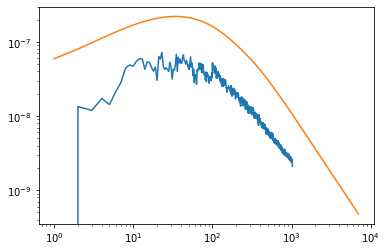

In [17]:
klm = kappa.coadd(0)
kappa.plot_coadd(0)

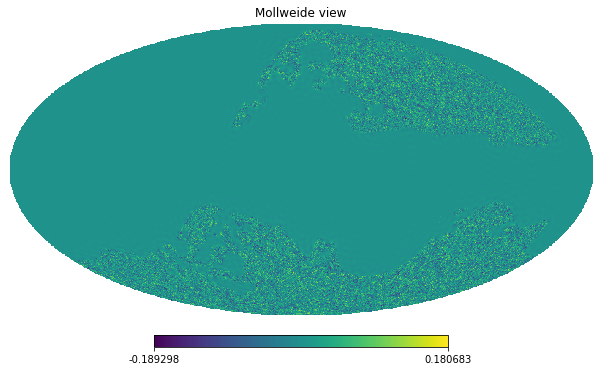

In [22]:
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,klm))

In [18]:
delens = Delenser(dire,filt,kappa,)

In [19]:
lensB = delens.lensing_B(0)

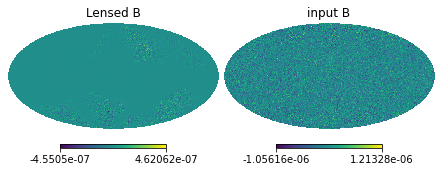

In [23]:
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,lensB),sub=(1,2,1),title='Lensed B')
hp.mollview(cs.utils.hp_alm2map(512,1024,1024,Bin),sub=(1,2,2),title='input B')

In [24]:
b1 = cs.utils.alm2cl(1024,lensB)
b2 = cs.utils.alm2cl(1024,Bin)
b12 = cs.utils.alm2cl(1024,lensB,Bin)
rho = b12/np.sqrt(b1*b2)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


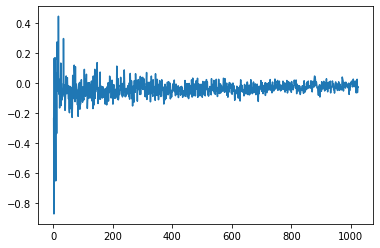

In [25]:
plt.plot(rho)

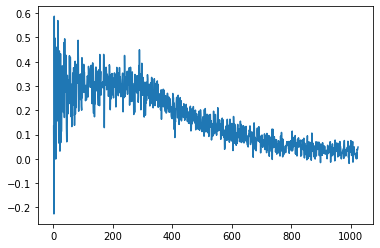

In [68]:
plt.plot(rho)